# Importing Libraries

In [1]:
import os, sys, glob, json, contextlib
import librosa
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader

# deal with a known bug in sklearn that pollutes stdout: https://stackoverflow.com/questions/52596204/the-imp-module-is-deprecated
with contextlib.redirect_stderr(None):
    from sklearn import metrics
    from sklearn.manifold import TSNE

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport src.dataloader
%aimport train
%aimport src.model 
import src.params
from IPython.display import display, Audio

# Load the model

In [6]:
model_dir = Path("../models/Round2TrainDataBestPerforming")
# NOTE: you can find the model on SharePoint here: 
# https://microsoft.sharepoint.com/:u:/t/OrcaCallAutomatedRecognitionSystemHackathon2019Project/Eci4Uj7ViN5PihR_ApzjD_MBOt7dmWSBDrDxYwKvnW6qVg?e=fXEEM5

net, curr_epoch = src.model.get_model_or_checkpoint("AudioSet_fc_all",str(model_dir),1,epoch=26)
net = net.eval()

Loaded checkpoint: ..\models\Round2TrainDataBestPerforming\AudioSet_fc_all_Iter_26


# Evaluate on Orcasound lab live test set

This is ~30min of field recordings from the Orcasound lab hydrophone on July 07, 2019 that were annotated by Scott as one of the test sets to measure performance in more realistic condititions. The distribution of labels here is a bit atypical as it contains many more positive examples than negative. 

Loaded mean and invstd from: ..\models\Round2TrainDataBestPerforming\mean64.txt ..\models\Round2TrainDataBestPerforming\invstd64.txt
Loading file: OS_7_05_2019_08_24_00_.wav
Total dataset size: 771


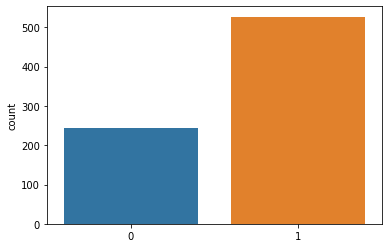

In [9]:
dataset_dir = Path("./data/test")

test_dataset = src.dataloader.AudioFileDataset(
    dataset_dir/"wav",dataset_dir/"test.tsv",mean=model_dir/"mean64.txt",invstd=model_dir/"invstd64.txt"
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)
print("Total dataset size:",len(test_dataset))
labels = [l[2] for l in test_dataset.windows]
sns.countplot(labels)

In [10]:
preds = []
scores = []
targets = []

for i, (data,target) in enumerate(test_dataloader):
    data, target = data.unsqueeze(1).float().cuda(), target.cuda() 
    logposterior, _ = net(data)
    scores.append(np.exp(logposterior.detach().cpu().numpy())[0,-1])
    targets.append(target.cpu().item())

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(targets,scores)
auc = metrics.auc(fpr,tpr)
print("AUC: {:.3f}".format(auc))

AUC: 0.924


<IPython.core.display.Javascript object>


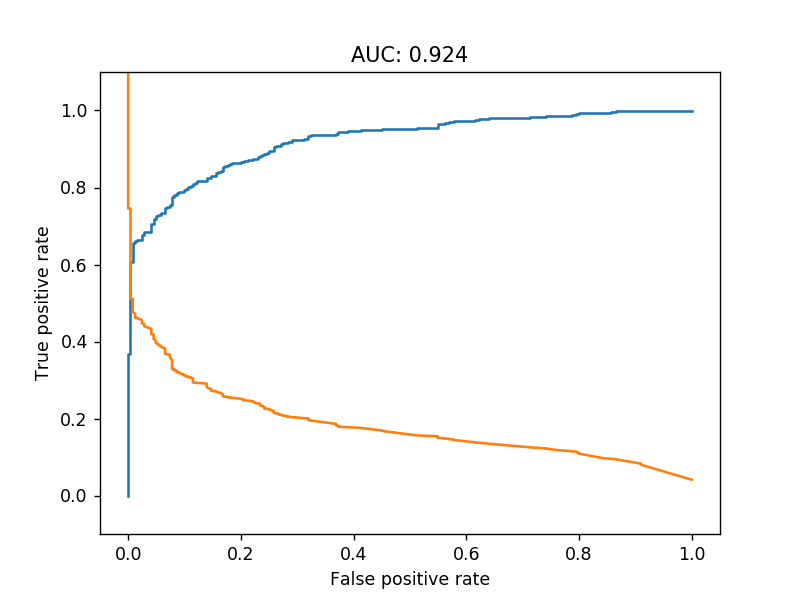

In [13]:
%matplotlib notebook
plt.plot(fpr,tpr)
plt.plot(fpr,thresholds)
plt.ylim((-0.1,1.1))
_ = plt.xlabel("False positive rate")
_ = plt.ylabel("True positive rate")
_ = plt.title("AUC: {:.3f}".format(auc))

In [23]:
threshold = 0.6 # threshold to pick when generating annotation candidates
preds = [ 1 if s > threshold else 0 for s in scores ]
print(metrics.classification_report(targets,preds))
print(metrics.confusion_matrix(targets,preds))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       244
           1       1.00      0.53      0.69       527

   micro avg       0.67      0.67      0.67       771
   macro avg       0.74      0.76      0.67       771
weighted avg       0.84      0.67      0.68       771

[[243   1]
 [250 277]]


In [36]:
predictionSubmission = pd.DataFrame({'score':scores})
predictionSubmission['StartTime']= predictionSubmission.index.values * 2.45
predictionSubmission['Duration'] = 2.45
predictionSubmission = predictionSubmission.loc[predictionSubmission.score > threshold].reset_index(drop=True)
predictionSubmission.to_csv('./predictionSubmission.csv', index=False)

# Creating a submission file

In [71]:
wav_file_paths = [ Path(p) for p in(dataset_dir/"wav").glob('*.wav') ]
audio_file_windower = src.dataloader.AudioFileWindower(wav_file_paths, 2.45, mean=model_dir/"mean64.txt",invstd=model_dir/"invstd64.txt")
audio_file_windower.get_mode = 'mel_spec'

<generator object Path.glob at 0x00000201FE729C78>

In [91]:
score = []
for i in range(len(audio_file_windower)):
    mel_spec_window, _ = audio_file_windower[i]

    # run inference on window
    input_data = torch.from_numpy(mel_spec_window).float().unsqueeze(0).unsqueeze(0)
    pred, embed = net(input_data)
    posterior = np.exp(pred.detach().cpu().numpy())
    score.append(round(float(posterior[0,1]),3))

In [98]:
predictionSubmission = pd.DataFrame({'score':score})
predictionSubmission['StartTime']= predictionSubmission.index.values * 2.45
predictionSubmission['Duration'] = 2.45
predictionSubmission = predictionSubmission.loc[predictionSubmission.score > threshold].reset_index(drop=True)
predictionSubmission.loc[:,['StartTime','Duration']].to_csv('./predictionSubmission.csv', index=False)

In [99]:
predictionSubmission

,score,StartTime,Duration
0,0.837,107.80,2.45
1,0.707,110.25,2.45
2,0.713,122.50,2.45
3,0.747,186.20,2.45
4,0.822,188.65,2.45
...,...,...,...
158,0.761,1668.45,2.45
159,0.668,1722.35,2.45
160,0.823,1744.40,2.45
161,0.646,1749.30,2.45
